In [2]:
import re, os, string
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import nltk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
dataname = 'IMDB Dataset.csv'
raw = pd.read_csv(dataname)
raw.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## **Naiviojo Bajeso klasifikatoriaus pritaikymas sentimentų analizei**

⚠️***Negalima importuoti jokių kitų paketų ar funkcijų, be tų kurie jau yra importuojami šio Notebook'o pradžioje!***

Užduotys:
1. Patikrinti, ar duomenyse yra tuščių (`NaN`) reikšmių.
1. Patikrinti, kokios yra klasės ir ar jos yra subalansuotos.
1. Patikrinti, ar duomenyse nėra keistų simbolių ar jų junginių.
1. Pakeisti klases į skaičius.
1. Tokenizuoti tekstą, pašalinti stop žodžius ir netinkamus klasifikavimui tokenus.
1. Suskirstyti tekstą į mokymosį ir testavimo rinkinius.
1. Apmokyti `MultinomialNB` modelį atlikti sentimentų analizę.
1. Gauti ir atvaizduoti painiavos matricą.
1. Paskaičiuoti tikslumą, preciziškumą, jautrumą, F1 metriką iš painiavos matricos.

1.

In [5]:
raw.isna().sum()

,0
text,0
label,0


2.

In [6]:
labels = raw["label"].unique()
print(labels)

[0 1]


Negative:20019 Positive:19981


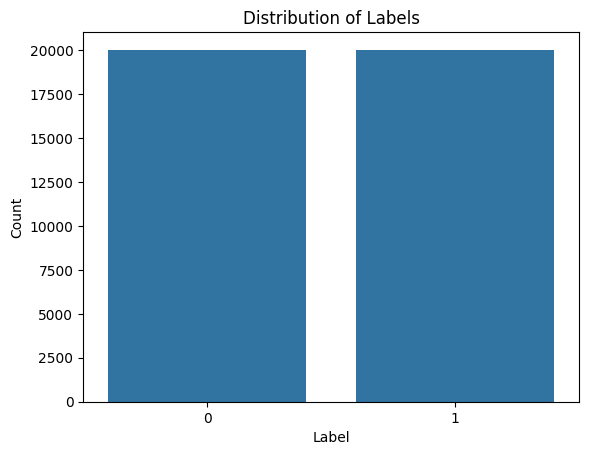

In [7]:
import seaborn as sns

negative = 0
positive = 0
for label in raw["label"]:
    if label == 0: negative += 1
    elif label == 1: positive += 1
print(F"Negative:{negative} Positive:{positive}")

sns.countplot(x='label', data=raw)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

3.

In [8]:
def check_unusual_chars(text):
    unusual_chars = re.findall(r'[^\w\s.,!?"\'$%&*()_+=\-\[\]{};:\'@#~`<>/\\|]', text)
    return list(set(unusual_chars))

unusual_found = {}
for index, row in raw.iterrows():
    unusual = check_unusual_chars(row['text'])
    if unusual:
        unusual_found[index] = unusual

if unusual_found:
    print("Unusual characters found.")
else:
    print("No unusual characters found.")

Unusual characters found.


5.

In [9]:
stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    tokens = text.split()

    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

raw['processed_text'] = raw['text'].apply(preprocess_text)


all_words = [word for sentence in raw['processed_text'] for word in sentence]
vocab = sorted(list(set(all_words)))

word_to_index = {word: i for i, word in enumerate(vocab)}
raw['numerical_processed_text'] = raw['processed_text'].apply(lambda tokens: [word_to_index[word] for word in tokens if word in word_to_index])

display(raw.head())

,text,label,processed_text,numerical_processed_text
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, b, watching, loving, thunderbirds, mate...","[56959, 9123, 148424, 79764, 137625, 83260, 11..."
1,"When I put this movie in my DVD player, and sa...",0,"[put, movie, dvd, player, sat, coke, chips, ex...","[108524, 89049, 39829, 103472, 117624, 25556, ..."
2,Why do people who do not know what a particula...,0,"[people, know, particular, time, past, like, f...","[101163, 73982, 100014, 137897, 100231, 77794,..."
3,Even though I have great interest in Biblical ...,0,"[even, though, great, interest, biblical, movi...","[43891, 137196, 56712, 68171, 13035, 89288, 15..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dads, army, fan, nothing, ever...","[65749, 35277, 59434, 31440, 6999, 46258, 9416..."


6.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(raw['numerical_processed_text'], raw['label'], test_size=0.2)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 32000
Testing set size: 8000


In [11]:
def to_bow_matrix(docs, vocab_size):
    """Converts a batch of documents to a Bag of Words matrix."""
    bow = np.zeros((len(docs), vocab_size), dtype=int)
    for i, tokens in enumerate(docs):
        for token in tokens:
            if token < vocab_size: # Safeguard
                bow[i, token] += 1
    return bow

# --- BATCH PROCESSING IMPLEMENTATION ---

# Initialize the Multinomial Naive Bayes model
model = MultinomialNB()
vocab_size = len(vocab)
all_classes = np.unique(raw['label'])
batch_size = 1000  # You can adjust this size based on your available RAM
num_batches = int(np.ceil(len(X_train) / batch_size))

# Train the model in batches
for i in tqdm(range(num_batches), desc="Training model in batches"):
    start = i * batch_size
    end = start + batch_size
    X_batch = X_train.iloc[start:end]
    y_batch = y_train.iloc[start:end]

    # Create BoW matrix for the current batch
    X_batch_bow = to_bow_matrix(X_batch, vocab_size)

    # Use partial_fit to train on the batch
    # The `classes` parameter needs to be provided for the first batch
    model.partial_fit(X_batch_bow, y_batch, classes=all_classes)

print("\nModel training completed.")

Training model in batches: 100%|██████████| 32/32 [01:00<00:00,  1.90s/it]


Model training completed.


7.

In [12]:
y_pred = []
num_test_batches = int(np.ceil(len(X_test) / batch_size))

for i in tqdm(range(num_test_batches), desc="Predicting on test set in batches"):
    start = i * batch_size
    end = start + batch_size
    X_test_batch = X_test.iloc[start:end]

    # Create BoW matrix for the current test batch
    X_test_batch_bow = to_bow_matrix(X_test_batch, vocab_size)

    # Predict on the batch and append results
    batch_preds = model.predict(X_test_batch_bow)
    y_pred.extend(batch_preds)

print("\nPrediction on test set completed.")

Predicting on test set in batches: 100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


Prediction on test set completed.


8.


Confusion Matrix:


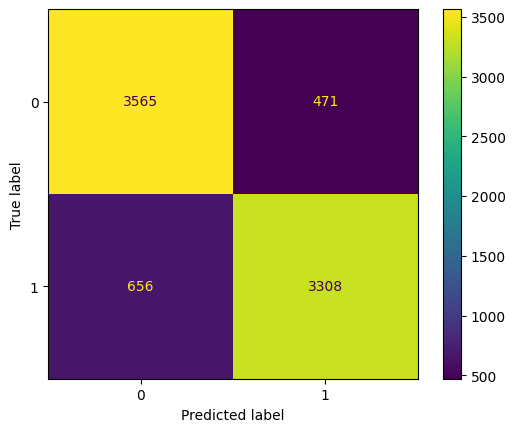

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=all_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)

print("\nConfusion Matrix:")
disp.plot()
plt.show()


9.

In [14]:
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Sensitivity is the same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.86
Precision: 0.88
Sensitivity (Recall): 0.83
F1 Score: 0.85


## **Naiviojo Bajeso klasifikatoriaus implementacija**

Peržvelkite kodo šabloną apačioje ir pabandykite pabaigti jį pagal formules, pateiktas skaidrėse:
1. Apskaičiuokite žodyno dydį mokymosi rinkiniui $V$;
1. Apskaičiuokite apriorines klasių tikimybes $P(c)$;
1. Apskaičiuokite, kiek kartų kiekvienas žodis pasitaiko poz. ar neg. klasės sakiniuose;
1. Apskaičiuokite kiekvieno žodžio tikimybę poz. ar neg. klasei, arba įvykio B atsiradimo tikimybė esant teisingai A hipotezei $P(w_i|c)$;
1. Galiausiai apskaičiuokite sentimento klases testavimo rinkiniui, naudojant `np.argmax()`.

In [36]:
print(f"Vocab size: {len(vocab)}\n")
print(f"Positive count: {raw['label'].value_counts()[1]}\n")
print(f"Negative count: {raw['label'].value_counts()[0]}\n")

total_word_count_0 = 0
total_word_count_1 = 0
for index, row in raw.iterrows():
    try:
        if row['label'] == 0:
            total_word_count_0 += len(row['processed_text'])
        elif row['label'] == 1:
            total_word_count_1 += len(row['processed_text'])
    except (ValueError, SyntaxError):
        print(f"Error in row {index}: {row}")

print(f"Word count for negative class: {total_word_count_0}\n")
print(f"Word count for positive class: {total_word_count_1}\n")


Vocab size: 154624

Positive count: 19981

Negative count: 20019

Word count for negative class: 2401697

Word count for positive class: 2455989



In [32]:

word_count_0 = {}
word_count_1 = {}
for index, row in raw.iterrows():
    try:
        if row['label'] == 0:
            for word in row['processed_text']:
                if word in word_count_0:
                    word_count_0[word] += 1
                else:
                    word_count_0[word] = 1
        elif row['label'] == 1:
            for word in row['processed_text']:
                if word in word_count_1:
                    word_count_1[word] += 1
                else:
                    word_count_1[word] = 1
    except (ValueError, SyntaxError):
        print(f"Error in row {index}: {row}")

print(f"Word dictionary for negative class: {word_count_0}\n")
print(f"Word dictionary for positive class: {word_count_1}\n")

Word dictionary for negative class: {'grew': 133, 'b': 577, 'watching': 4213, 'loving': 123, 'thunderbirds': 52, 'mates': 50, 'school': 1345, 'watched': 1800, 'played': 1627, 'lunch': 45, 'wanted': 1262, 'virgil': 13, 'scott': 320, 'one': 19927, 'alan': 182, 'counting': 34, 'became': 475, 'art': 731, 'form': 481, 'took': 906, 'children': 856, 'see': 8447, 'movie': 38050, 'hoping': 431, 'would': 10899, 'get': 8020, 'glimpse': 80, 'loved': 539, 'child': 797, 'bitterly': 24, 'disappointing': 485, 'high': 1540, 'point': 2730, 'snappy': 26, 'theme': 482, 'tune': 98, 'could': 7224, 'compare': 246, 'original': 2860, 'score': 641, 'thankfully': 157, 'early': 1047, 'saturday': 170, 'mornings': 7, 'television': 561, 'channel': 442, 'still': 3564, 'plays': 1352, 'reruns': 45, 'series': 1845, 'gerry': 15, 'anderson': 130, 'wife': 1252, 'created': 372, 'jonatha': 1, 'frakes': 8, 'hand': 838, 'directors': 706, 'chair': 136, 'version': 1440, 'completely': 1897, 'hopeless': 64, 'waste': 2074, 'film': 

In [60]:
def get_word_counts(train_x, train_y):
    word_count_pos = {}
    word_count_neg = {}

    for i in range(len(train_x)):
        words = train_x[i]
        label = train_y[i]

        for w in words:
            if label == 1:
                if w not in word_count_pos:
                    word_count_pos[w] = 0
                word_count_pos[w] += 1
            else:
                if w not in word_count_neg:
                    word_count_neg[w] = 0
                word_count_neg[w] += 1

    return word_count_pos, word_count_neg


def naive_bayes_prediction(train_x: list[list[str]], train_y: list[int], test_x: list[list[str]]) -> list[int]:

    vocab = set(word for sent in train_x for word in sent)
    vocab_size = len(vocab) # int
    prior_pos = sum(1 for y in train_y if y == 1)/len(train_y)  # float
    prior_neg = sum(1 for y in train_y if y == 0)/len(train_y)  # float

    # kiek kart kiekvienas žodis pasitaiko poz. ar neg. sakiniuose
    word_count_pos, word_count_neg = get_word_counts(train_x, train_y)  # dict
    #assert len(word_count_pos) == len(word_count_neg)

    # kiek iš viso yra žodžių visuose poz. ar neg. sakiniuose
    total_word_count_pos = sum(word_count_pos.values()) # int
    total_word_count_neg = sum(word_count_neg.values())  # int

    # kiekvieno žodžio tikimybė poz. ar neg. klasei
    likelihood_pos = {word: (word_count_pos.get(word, 0) + 1) / (total_word_count_pos + vocab_size) for word in vocab}   # dict
    likelihood_neg = {word: (word_count_neg.get(word, 0) + 1) / (total_word_count_neg + vocab_size) for word in vocab}   # dict

    # sentimentų klasių prognozė
    predictions = []
    for sentence in test_x:
        positive_prob = np.log(prior_pos) + sum(np.log(likelihood_pos[word]) for word in sentence if word in vocab)
        negative_prob = np.log(prior_neg) + sum(np.log(likelihood_neg[word]) for word in sentence if word in vocab)
        predicted_class = np.argmax([negative_prob, positive_prob])
        assert predicted_class in [0, 1]
        predictions.append(predicted_class)

    return predictions

Palyginkite šios funkcijos klasifikavimo tikslumą su `MultinomialNB` modelio tikslumu.

In [69]:
X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = list(y_train)
predictions = naive_bayes_prediction(X_train, y_train, X_test)


Confusion Matrix:


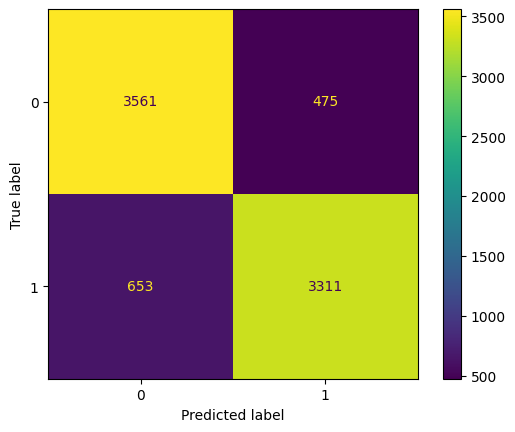

In [70]:
cm2 = confusion_matrix(y_test, predictions, labels=all_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=all_classes)

print("\nConfusion Matrix:")
disp.plot()
plt.show()

In [71]:
tn2, fp2, fn2, tp2 = cm2.ravel()

accuracy2 = (tp2 + tn2) / (tp2 + tn2 + fp2 + fn2)
precision2 = tp2 / (tp2 + fp2)
recall2 = tp2 / (tp2 + fn2) # Sensitivity is the same as recall
f1_2 = 2 * (precision2 * recall2) / (precision2 + recall2)

print(f"Accuracy: {accuracy2:.2f}")
print(f"Precision: {precision2:.2f}")
print(f"Sensitivity (Recall): {recall2:.2f}")
print(f"F1 Score: {f1_2:.2f}")

Accuracy: 0.86
Precision: 0.87
Sensitivity (Recall): 0.84
F1 Score: 0.85


Šio modelio tikslumai labai panašūs į MultinomialNB modelio tisklumus.